# FAIRFACE - Age Estimation and Gender Classification with Multi-Task Learning

## Imports

In [1]:
import glob
import re
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Dataset

In [2]:
trn_df = pd.read_csv('fairface_label_train.csv')
val_df = pd.read_csv('fairface_label_val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [3]:
class GenderAgeClass(Dataset):
    """
    Takes a filename as input and returns the corresponding image, gender, and scaled age.
    """
    def __init__(self, df, im_size=224, tfms=None): 
        self.df = df
        self.im_size = im_size # Imagenet standards
        # http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/models.html
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Imagenet standards
        self.dict_age = {'0-2': 0,
                         '3-9': 1,
                         '10-19': 2,
                         '20-29': 3,
                         '30-39': 4,
                         '40-49': 5,
                         '50-59': 6,
                         '60-69': 7,
                         'more than 70': 8} 
        
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, float(self.dict_age[age]), gen

    def preprocess_image(self, im):
        im = cv2.resize(im, (self.im_size, self.im_size))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        #preprocess images, ages and genders
        ims, ages, genders = [], [], []

        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)
            ages.append(age)
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device) for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages.type(torch.LongTensor), genders
    
    def get_age(self, age):
        key_list = list(self.dict_age.keys())
        val_list = list(self.dict_age.values())
        position = val_list.index(age)
        return key_list[position]

In [4]:
def display_image(im, title="sth", cmap='gray', fig_size=(5, 5)):
    """
    Display images.
    """
    plt.figure(figsize=fig_size)       
    plt.title(title)
    plt.imshow(im, cmap=cmap)        
    plt.show()

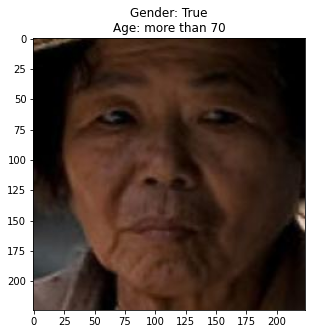

In [5]:
train = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
im, age, gen = val[10]
# false => male & true => female
display_image(im, title=f'Gender: {gen}\nAge: {train.get_age(age)}')

In [6]:
train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True, collate_fn=train.collate_fn)
a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
print(c)
print(b)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([3, 4, 4, 3, 1, 5, 4, 5, 2, 6, 5, 7, 3, 4, 3, 3, 6, 5, 2, 3, 6, 3, 4, 5,
        2, 5, 4, 3, 3, 4, 5, 3])


In [7]:
class ageGenderClassifier(nn.Module):
    """
    ANN multi-task learning class for both VGG16 and RESNET34
    """
    def __init__(self, num_age_classes=9, dropout=0.1):

        super(ageGenderClassifier, self).__init__()

        self.intermediate = nn.Sequential(
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2,inplace=True), 
        )

        self.age_classifier = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(16, num_age_classes)
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        #print(x.shape)
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return gender, age

## Model vgg16

In [51]:
model = models.vgg16(pretrained = True)
# Freeze parameters => no backprop 
for param in model.parameters():
    param.requires_grad = False
model.avgpool = nn.Sequential(nn.Conv2d(512,512, kernel_size=3),
                              nn.MaxPool2d(2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(2048,512),
                              nn.LeakyReLU(0.2,inplace=True))

model.classifier = ageGenderClassifier()
gender_criterion = nn.BCELoss()
age_criterion = nn.CrossEntropyLoss()
loss_functions = gender_criterion, age_criterion
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)   
model = model.to(device)
#print(model)

## Model resnet34

In [8]:
model = models.resnet34(pretrained = True)
# Freeze parameters => no backprop 
for param in model.parameters():
    param.requires_grad = False
model.avgpool = nn.Sequential(nn.Conv2d(512,512, kernel_size=3), 
                              nn.MaxPool2d(2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(2048,512),
                              nn.LeakyReLU(0.2,inplace=True)
                              ) #nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = ageGenderClassifier()
    
gender_criterion = nn.BCELoss()
age_criterion = nn.CrossEntropyLoss()
    
loss_functions = gender_criterion, age_criterion
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)   
model = model.to(device)
#print(model)

## Model

In [9]:
def train_batch(data, model, optimizer, criteria, fst_age_loss=1, fst_gender_loss=3):
    model.train()    
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims) 
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)  
    #total_loss = (gender_loss/fst_gender_loss) + (age_loss/fst_age_loss)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum() / pred_gender.shape[0]
    age_acc = (pred_age.argmax(dim=1) == age).float().sum() / pred_gender.shape[0]
    return total_loss, gender_acc, age_acc


def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum() / pred_gender.shape[0]
    age_acc = (pred_age.argmax(dim=1) == age).float().sum() / pred_gender.shape[0]
    return total_loss, gender_acc, age_acc

## Train

In [12]:
%load_ext tensorboard
%tensorboard --logdir=runs --port 8679

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
#writer = SummaryWriter("runs/VGG16")
writer = SummaryWriter("runs/RESNET34")

In [14]:
im = cv2.imread('me.jpg')
test_data = train.preprocess_image(im).to(device)

batch_size = 32
n_epochs = 1

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train.collate_fn)
test_loader = DataLoader(val, batch_size=batch_size, collate_fn=val.collate_fn)

_train_losses = []
_val_losses = []

for epoch in range(n_epochs):
    for n_iter, data in enumerate(train_loader):
        loss, gender_acc, age_acc = train_batch(data, model, optimizer, loss_functions)
        _train_losses.append(n_iter)
        writer.add_scalar('Loss/train', loss.item(), len(_train_losses)) 
        writer.add_scalar('Acc_Gender/train', gender_acc, len(_train_losses))
        writer.add_scalar('Acc_Age/train', age_acc, len(_train_losses))
        ##################################################################
        model.eval()
        gender, age = model(test_data)
        pred_gender = gender.to('cpu').detach().numpy()
        pred_age = torch.argmax(age, dim=1).detach().numpy()
        print('Predicted gender:', np.where(pred_gender[0][0] < 0.5, 'Male','Female'), pred_gender[0][0])
        print('Predicted age:', train.get_age(pred_age)) 

    print("################################## Test ##################################")

    for n_iter, data in enumerate(test_loader):
        loss, gender_acc, age_acc = validate_batch(data, model, loss_functions)
        _val_losses.append(n_iter)
        writer.add_scalar('Loss/test', loss.item(), len(_val_losses))
        writer.add_scalar('Acc_Gender/test', gender_acc, len(_val_losses))
        writer.add_scalar('Acc_Age/test', age_acc, len(_val_losses))
        

Predicted gender: Male 0.48249114
Predicted age: 3-9
Predicted gender: Male 0.48262724
Predicted age: 3-9
Predicted gender: Male 0.48220918
Predicted age: 3-9
Predicted gender: Male 0.4829388
Predicted age: 3-9
Predicted gender: Male 0.4837984
Predicted age: 3-9
Predicted gender: Male 0.48501444
Predicted age: 3-9
Predicted gender: Male 0.48693717
Predicted age: 3-9
Predicted gender: Male 0.48898113
Predicted age: 3-9
Predicted gender: Male 0.49178633
Predicted age: 3-9
Predicted gender: Male 0.49401313
Predicted age: 3-9
Predicted gender: Male 0.49494565
Predicted age: 3-9
Predicted gender: Male 0.49755204
Predicted age: 3-9
Predicted gender: Female 0.50187653
Predicted age: 3-9
Predicted gender: Female 0.5037375
Predicted age: 3-9
Predicted gender: Female 0.5058115
Predicted age: 3-9
Predicted gender: Female 0.50370836
Predicted age: 3-9
Predicted gender: Male 0.49937242
Predicted age: 3-9
Predicted gender: Male 0.49889055
Predicted age: 3-9
Predicted gender: Male 0.4949728
Predicted

Predicted gender: Male 0.35102105
Predicted age: 3-9
Predicted gender: Male 0.365592
Predicted age: 3-9
Predicted gender: Male 0.36971045
Predicted age: 3-9
Predicted gender: Male 0.36078328
Predicted age: 3-9
Predicted gender: Male 0.37101075
Predicted age: 3-9
Predicted gender: Male 0.38909552
Predicted age: 3-9
Predicted gender: Male 0.38518697
Predicted age: 3-9
Predicted gender: Male 0.38500163
Predicted age: 3-9
Predicted gender: Male 0.37163106
Predicted age: 3-9
Predicted gender: Male 0.38013583
Predicted age: 3-9
Predicted gender: Male 0.3840964
Predicted age: 3-9
Predicted gender: Male 0.3763301
Predicted age: 3-9
Predicted gender: Male 0.36044538
Predicted age: 3-9
Predicted gender: Male 0.34159708
Predicted age: 3-9
Predicted gender: Male 0.31112733
Predicted age: 3-9
Predicted gender: Male 0.29120332
Predicted age: 3-9
Predicted gender: Male 0.27615497
Predicted age: 3-9
Predicted gender: Male 0.2434223
Predicted age: 3-9
Predicted gender: Male 0.22126776
Predicted age: 3-

Predicted gender: Male 0.22937322
Predicted age: 3-9
Predicted gender: Male 0.22032562
Predicted age: 3-9
Predicted gender: Male 0.20996447
Predicted age: 3-9
Predicted gender: Male 0.22477119
Predicted age: 3-9
Predicted gender: Male 0.23270124
Predicted age: 3-9
Predicted gender: Male 0.2258466
Predicted age: 3-9
Predicted gender: Male 0.22683252
Predicted age: 3-9
Predicted gender: Male 0.23632571
Predicted age: 3-9
Predicted gender: Male 0.22977632
Predicted age: 3-9
Predicted gender: Male 0.22970721
Predicted age: 3-9
Predicted gender: Male 0.24087371
Predicted age: 3-9
Predicted gender: Male 0.24023274
Predicted age: 3-9
Predicted gender: Male 0.23343118
Predicted age: 3-9
Predicted gender: Male 0.23535691
Predicted age: 3-9
Predicted gender: Male 0.23436642
Predicted age: 3-9
Predicted gender: Male 0.2416571
Predicted age: 3-9
Predicted gender: Male 0.24951701
Predicted age: 3-9
Predicted gender: Male 0.26761785
Predicted age: 3-9
Predicted gender: Male 0.26847348
Predicted age:

Predicted gender: Male 0.18455437
Predicted age: 30-39
Predicted gender: Male 0.19386457
Predicted age: 30-39
Predicted gender: Male 0.21194962
Predicted age: 30-39
Predicted gender: Male 0.22781773
Predicted age: 30-39
Predicted gender: Male 0.24333489
Predicted age: 30-39
Predicted gender: Male 0.26240957
Predicted age: 30-39
Predicted gender: Male 0.29385078
Predicted age: 30-39
Predicted gender: Male 0.31803656
Predicted age: 30-39
Predicted gender: Male 0.33631435
Predicted age: 30-39
Predicted gender: Male 0.32791588
Predicted age: 30-39
Predicted gender: Male 0.30341232
Predicted age: 30-39
Predicted gender: Male 0.28555617
Predicted age: 30-39
Predicted gender: Male 0.28777254
Predicted age: 30-39
Predicted gender: Male 0.3071101
Predicted age: 30-39
Predicted gender: Male 0.3110167
Predicted age: 30-39
Predicted gender: Male 0.3283633
Predicted age: 30-39
Predicted gender: Male 0.33596843
Predicted age: 3-9
Predicted gender: Male 0.31459385
Predicted age: 3-9
Predicted gender:

Predicted gender: Male 0.15658405
Predicted age: 3-9
Predicted gender: Male 0.15609474
Predicted age: 3-9
Predicted gender: Male 0.15670241
Predicted age: 3-9
Predicted gender: Male 0.1579561
Predicted age: 3-9
Predicted gender: Male 0.15632753
Predicted age: 3-9
Predicted gender: Male 0.15670705
Predicted age: 3-9
Predicted gender: Male 0.14662112
Predicted age: 3-9
Predicted gender: Male 0.14723928
Predicted age: 3-9
Predicted gender: Male 0.15737897
Predicted age: 3-9
Predicted gender: Male 0.16266459
Predicted age: 3-9
Predicted gender: Male 0.16642222
Predicted age: 3-9
Predicted gender: Male 0.17409804
Predicted age: 3-9
Predicted gender: Male 0.1638283
Predicted age: 3-9
Predicted gender: Male 0.15487692
Predicted age: 3-9
Predicted gender: Male 0.14192773
Predicted age: 3-9
Predicted gender: Male 0.1373553
Predicted age: 3-9
Predicted gender: Male 0.14870322
Predicted age: 3-9
Predicted gender: Male 0.14485979
Predicted age: 3-9
Predicted gender: Male 0.12982665
Predicted age: 

Predicted gender: Male 0.15360713
Predicted age: 3-9
Predicted gender: Male 0.17033347
Predicted age: 3-9
Predicted gender: Male 0.19102299
Predicted age: 3-9
Predicted gender: Male 0.1933622
Predicted age: 3-9
Predicted gender: Male 0.2155089
Predicted age: 3-9
Predicted gender: Male 0.21804124
Predicted age: 3-9
Predicted gender: Male 0.24313554
Predicted age: 3-9
Predicted gender: Male 0.2543914
Predicted age: 3-9
Predicted gender: Male 0.27183893
Predicted age: 3-9
Predicted gender: Male 0.27909297
Predicted age: 3-9
Predicted gender: Male 0.29577747
Predicted age: 3-9
Predicted gender: Male 0.30526185
Predicted age: 3-9
Predicted gender: Male 0.29402092
Predicted age: 3-9
Predicted gender: Male 0.3032585
Predicted age: 3-9
Predicted gender: Male 0.288739
Predicted age: 3-9
Predicted gender: Male 0.28109738
Predicted age: 3-9
Predicted gender: Male 0.25507474
Predicted age: 3-9
Predicted gender: Male 0.2621285
Predicted age: 3-9
Predicted gender: Male 0.25665158
Predicted age: 3-9


Predicted gender: Male 0.12665825
Predicted age: 3-9
Predicted gender: Male 0.13042311
Predicted age: 3-9
Predicted gender: Male 0.13262102
Predicted age: 3-9
Predicted gender: Male 0.13717237
Predicted age: 3-9
Predicted gender: Male 0.13764183
Predicted age: 3-9
Predicted gender: Male 0.13865092
Predicted age: 3-9
Predicted gender: Male 0.14833573
Predicted age: 3-9
Predicted gender: Male 0.16324602
Predicted age: 3-9
Predicted gender: Male 0.17526007
Predicted age: 3-9
Predicted gender: Male 0.1805187
Predicted age: 3-9
Predicted gender: Male 0.19876914
Predicted age: 3-9
Predicted gender: Male 0.21780536
Predicted age: 3-9
Predicted gender: Male 0.22049066
Predicted age: 3-9
Predicted gender: Male 0.20218614
Predicted age: 3-9
Predicted gender: Male 0.19246976
Predicted age: 3-9
Predicted gender: Male 0.1791146
Predicted age: 3-9
Predicted gender: Male 0.16846958
Predicted age: 3-9
Predicted gender: Male 0.17014065
Predicted age: 3-9
Predicted gender: Male 0.17597948
Predicted age:

Predicted gender: Male 0.10519373
Predicted age: 3-9
Predicted gender: Male 0.10495648
Predicted age: 3-9
Predicted gender: Male 0.10959535
Predicted age: 3-9
Predicted gender: Male 0.10582656
Predicted age: 3-9
Predicted gender: Male 0.09989156
Predicted age: 3-9
Predicted gender: Male 0.10915216
Predicted age: 3-9
Predicted gender: Male 0.11038789
Predicted age: 3-9
Predicted gender: Male 0.106151305
Predicted age: 3-9
Predicted gender: Male 0.10032831
Predicted age: 3-9
Predicted gender: Male 0.1014289
Predicted age: 3-9
Predicted gender: Male 0.0981504
Predicted age: 3-9
Predicted gender: Male 0.10002648
Predicted age: 3-9
Predicted gender: Male 0.10453217
Predicted age: 3-9
Predicted gender: Male 0.10960706
Predicted age: 3-9
Predicted gender: Male 0.11428036
Predicted age: 3-9
Predicted gender: Male 0.12142742
Predicted age: 3-9
Predicted gender: Male 0.12584324
Predicted age: 3-9
Predicted gender: Male 0.122251
Predicted age: 3-9
Predicted gender: Male 0.1267978
Predicted age: 3

Predicted gender: Male 0.251538
Predicted age: 3-9
Predicted gender: Male 0.20673878
Predicted age: 3-9
Predicted gender: Male 0.16847837
Predicted age: 3-9
Predicted gender: Male 0.13844925
Predicted age: 30-39
Predicted gender: Male 0.12210839
Predicted age: 30-39
Predicted gender: Male 0.1051632
Predicted age: 30-39
Predicted gender: Male 0.09474976
Predicted age: 30-39
Predicted gender: Male 0.09362488
Predicted age: 30-39
Predicted gender: Male 0.08071841
Predicted age: 30-39
Predicted gender: Male 0.07149336
Predicted age: 30-39
Predicted gender: Male 0.07169291
Predicted age: 30-39
Predicted gender: Male 0.064804725
Predicted age: 30-39
Predicted gender: Male 0.06537597
Predicted age: 30-39
Predicted gender: Male 0.06348949
Predicted age: 30-39
Predicted gender: Male 0.06640487
Predicted age: 30-39
Predicted gender: Male 0.06338249
Predicted age: 30-39
Predicted gender: Male 0.0697697
Predicted age: 30-39
Predicted gender: Male 0.07525104
Predicted age: 30-39
Predicted gender: M

Predicted gender: Male 0.13122092
Predicted age: 3-9
Predicted gender: Male 0.12695177
Predicted age: 3-9
Predicted gender: Male 0.12752667
Predicted age: 3-9
Predicted gender: Male 0.12317523
Predicted age: 3-9
Predicted gender: Male 0.11934669
Predicted age: 3-9
Predicted gender: Male 0.11847366
Predicted age: 3-9
Predicted gender: Male 0.11584383
Predicted age: 3-9
Predicted gender: Male 0.11187269
Predicted age: 3-9
Predicted gender: Male 0.1146128
Predicted age: 3-9
Predicted gender: Male 0.11906144
Predicted age: 3-9
Predicted gender: Male 0.1217582
Predicted age: 3-9
Predicted gender: Male 0.12869723
Predicted age: 3-9
Predicted gender: Male 0.1361337
Predicted age: 3-9
Predicted gender: Male 0.12644938
Predicted age: 3-9
Predicted gender: Male 0.12417517
Predicted age: 3-9
Predicted gender: Male 0.13065638
Predicted age: 3-9
Predicted gender: Male 0.13937351
Predicted age: 3-9
Predicted gender: Male 0.139355
Predicted age: 3-9
Predicted gender: Male 0.12712097
Predicted age: 3-

Predicted gender: Male 0.051714245
Predicted age: 3-9
Predicted gender: Male 0.049553268
Predicted age: 3-9
Predicted gender: Male 0.051622476
Predicted age: 3-9
Predicted gender: Male 0.050203755
Predicted age: 30-39
Predicted gender: Male 0.05031082
Predicted age: 30-39
Predicted gender: Male 0.052166995
Predicted age: 30-39
Predicted gender: Male 0.05367182
Predicted age: 30-39
Predicted gender: Male 0.0611353
Predicted age: 3-9
Predicted gender: Male 0.059161037
Predicted age: 30-39
Predicted gender: Male 0.06361245
Predicted age: 30-39
Predicted gender: Male 0.07114294
Predicted age: 30-39
Predicted gender: Male 0.070998445
Predicted age: 30-39
Predicted gender: Male 0.07921954
Predicted age: 30-39
Predicted gender: Male 0.080412224
Predicted age: 30-39
Predicted gender: Male 0.0819849
Predicted age: 3-9
Predicted gender: Male 0.08285911
Predicted age: 3-9
Predicted gender: Male 0.08717021
Predicted age: 30-39
Predicted gender: Male 0.088392
Predicted age: 30-39
Predicted gender: 

Predicted gender: Male 0.07540479
Predicted age: 3-9
Predicted gender: Male 0.06673393
Predicted age: 3-9
Predicted gender: Male 0.06366613
Predicted age: 3-9
Predicted gender: Male 0.059666786
Predicted age: 3-9
Predicted gender: Male 0.056164123
Predicted age: 3-9
Predicted gender: Male 0.053966768
Predicted age: 30-39
Predicted gender: Male 0.05487318
Predicted age: 30-39
Predicted gender: Male 0.063510306
Predicted age: 3-9
Predicted gender: Male 0.06512662
Predicted age: 3-9
Predicted gender: Male 0.06809065
Predicted age: 3-9
Predicted gender: Male 0.078757234
Predicted age: 3-9
Predicted gender: Male 0.077600285
Predicted age: 3-9
Predicted gender: Male 0.074395545
Predicted age: 3-9
Predicted gender: Male 0.07613174
Predicted age: 3-9
Predicted gender: Male 0.076711796
Predicted age: 3-9
Predicted gender: Male 0.08034234
Predicted age: 3-9
Predicted gender: Male 0.079337046
Predicted age: 3-9
Predicted gender: Male 0.07455974
Predicted age: 3-9
Predicted gender: Male 0.07279575

Predicted gender: Male 0.04426352
Predicted age: 30-39
Predicted gender: Male 0.040254485
Predicted age: 30-39
Predicted gender: Male 0.03654641
Predicted age: 30-39
Predicted gender: Male 0.03390927
Predicted age: 30-39
Predicted gender: Male 0.028876768
Predicted age: 30-39
Predicted gender: Male 0.027936233
Predicted age: 30-39
Predicted gender: Male 0.030406008
Predicted age: 30-39
Predicted gender: Male 0.026971431
Predicted age: 30-39
Predicted gender: Male 0.022031695
Predicted age: 30-39
Predicted gender: Male 0.01939346
Predicted age: 30-39
Predicted gender: Male 0.018517679
Predicted age: 30-39
Predicted gender: Male 0.019515451
Predicted age: 30-39
Predicted gender: Male 0.019835858
Predicted age: 30-39
Predicted gender: Male 0.018912164
Predicted age: 30-39
Predicted gender: Male 0.017965857
Predicted age: 30-39
Predicted gender: Male 0.017377505
Predicted age: 30-39
Predicted gender: Male 0.015956696
Predicted age: 30-39
Predicted gender: Male 0.015386154
Predicted age: 30

Predicted gender: Male 0.024582485
Predicted age: 30-39
Predicted gender: Male 0.025353402
Predicted age: 30-39
Predicted gender: Male 0.025319982
Predicted age: 30-39
Predicted gender: Male 0.028179001
Predicted age: 30-39
Predicted gender: Male 0.024865737
Predicted age: 30-39
Predicted gender: Male 0.02616315
Predicted age: 30-39
Predicted gender: Male 0.02695068
Predicted age: 30-39
Predicted gender: Male 0.027842727
Predicted age: 30-39
Predicted gender: Male 0.023638716
Predicted age: 30-39
Predicted gender: Male 0.022269158
Predicted age: 30-39
Predicted gender: Male 0.024532877
Predicted age: 30-39
Predicted gender: Male 0.024656385
Predicted age: 30-39
Predicted gender: Male 0.021827813
Predicted age: 30-39
Predicted gender: Male 0.021787904
Predicted age: 30-39
Predicted gender: Male 0.022169307
Predicted age: 30-39
Predicted gender: Male 0.02320351
Predicted age: 30-39
Predicted gender: Male 0.022653053
Predicted age: 30-39
Predicted gender: Male 0.024748906
Predicted age: 3

Predicted gender: Male 0.035497047
Predicted age: 30-39
Predicted gender: Male 0.038990486
Predicted age: 30-39
Predicted gender: Male 0.039575193
Predicted age: 30-39
Predicted gender: Male 0.045425266
Predicted age: 30-39
Predicted gender: Male 0.047066312
Predicted age: 30-39
Predicted gender: Male 0.048795205
Predicted age: 30-39
Predicted gender: Male 0.05341518
Predicted age: 30-39
Predicted gender: Male 0.058212657
Predicted age: 30-39
Predicted gender: Male 0.05230609
Predicted age: 30-39
Predicted gender: Male 0.056498736
Predicted age: 30-39
Predicted gender: Male 0.057800442
Predicted age: 30-39
Predicted gender: Male 0.05726986
Predicted age: 30-39
Predicted gender: Male 0.058390915
Predicted age: 30-39
Predicted gender: Male 0.060869444
Predicted age: 30-39
Predicted gender: Male 0.059620187
Predicted age: 30-39
Predicted gender: Male 0.062787764
Predicted age: 30-39
Predicted gender: Male 0.062375512
Predicted age: 30-39
Predicted gender: Male 0.064510696
Predicted age: 3

Predicted gender: Male 0.053083364
Predicted age: 30-39
Predicted gender: Male 0.044476457
Predicted age: 30-39
Predicted gender: Male 0.043019246
Predicted age: 30-39
Predicted gender: Male 0.04080516
Predicted age: 30-39
Predicted gender: Male 0.040377364
Predicted age: 30-39
Predicted gender: Male 0.037557945
Predicted age: 30-39
Predicted gender: Male 0.037860323
Predicted age: 30-39
Predicted gender: Male 0.03904847
Predicted age: 30-39
Predicted gender: Male 0.041651644
Predicted age: 30-39
Predicted gender: Male 0.047836244
Predicted age: 30-39
Predicted gender: Male 0.054670442
Predicted age: 30-39
Predicted gender: Male 0.058162868
Predicted age: 30-39
Predicted gender: Male 0.06264261
Predicted age: 30-39
Predicted gender: Male 0.06372756
Predicted age: 30-39
Predicted gender: Male 0.07026401
Predicted age: 20-29
Predicted gender: Male 0.06956689
Predicted age: 20-29
Predicted gender: Male 0.07709566
Predicted age: 20-29
Predicted gender: Male 0.07922542
Predicted age: 20-29


Predicted gender: Male 0.052494984
Predicted age: 30-39
Predicted gender: Male 0.04328451
Predicted age: 30-39
Predicted gender: Male 0.044389218
Predicted age: 30-39
Predicted gender: Male 0.04050691
Predicted age: 30-39
Predicted gender: Male 0.039441444
Predicted age: 30-39
Predicted gender: Male 0.039715547
Predicted age: 30-39
Predicted gender: Male 0.041477367
Predicted age: 30-39
Predicted gender: Male 0.0407105
Predicted age: 30-39
Predicted gender: Male 0.040172447
Predicted age: 30-39
Predicted gender: Male 0.042006016
Predicted age: 30-39
Predicted gender: Male 0.04288121
Predicted age: 30-39
Predicted gender: Male 0.04783658
Predicted age: 30-39
Predicted gender: Male 0.04464305
Predicted age: 30-39
Predicted gender: Male 0.048809938
Predicted age: 30-39
Predicted gender: Male 0.050265558
Predicted age: 30-39
Predicted gender: Male 0.048144262
Predicted age: 20-29
Predicted gender: Male 0.050320763
Predicted age: 20-29
Predicted gender: Male 0.05598548
Predicted age: 20-29


Predicted gender: Male 0.017506957
Predicted age: 20-29
Predicted gender: Male 0.017298313
Predicted age: 20-29
Predicted gender: Male 0.018878924
Predicted age: 20-29
Predicted gender: Male 0.021035967
Predicted age: 30-39
Predicted gender: Male 0.02243532
Predicted age: 30-39
Predicted gender: Male 0.019825872
Predicted age: 30-39
Predicted gender: Male 0.018874327
Predicted age: 30-39
Predicted gender: Male 0.01644099
Predicted age: 30-39
Predicted gender: Male 0.01639794
Predicted age: 30-39
Predicted gender: Male 0.015510396
Predicted age: 30-39
Predicted gender: Male 0.015627189
Predicted age: 30-39
Predicted gender: Male 0.015506668
Predicted age: 30-39
Predicted gender: Male 0.015003717
Predicted age: 30-39
Predicted gender: Male 0.014157431
Predicted age: 30-39
Predicted gender: Male 0.01572414
Predicted age: 30-39
Predicted gender: Male 0.019731626
Predicted age: 30-39
Predicted gender: Male 0.021819752
Predicted age: 30-39
Predicted gender: Male 0.022640787
Predicted age: 30

In [15]:
#torch.save(model.state_dict(), "inferences/vgg16.pt")
torch.save(model.state_dict(), "inferences/resnet34.pt")

## Inference - VGG16

In [43]:
model = models.vgg16(pretrained = True)
# Freeze parameters => no backprop 
for param in model.parameters():
    param.requires_grad = False
model.avgpool = nn.Sequential(nn.Conv2d(512,512, kernel_size=3),
                              nn.MaxPool2d(2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(2048,512),
                              nn.LeakyReLU(0.2,inplace=True))
model.classifier = ageGenderClassifier()
model.load_state_dict(torch.load("inferences/vgg16.pt"))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Inference - RESNET34

In [18]:
model = models.resnet34(pretrained = True)
# Freeze parameters => no backprop 
for param in model.parameters():
    param.requires_grad = False
model.avgpool = nn.Sequential(nn.Conv2d(512,512, kernel_size=3), 
                              nn.MaxPool2d(2),
                              nn.ReLU(),
                              nn.Flatten(),
                              nn.Linear(2048,512),
                              nn.LeakyReLU(0.2,inplace=True)
                              ) #nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.fc = ageGenderClassifier()
model.load_state_dict(torch.load("inferences/resnet34.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Test

Predicted gender: Female 0.62007797
Predicted age: 20-29


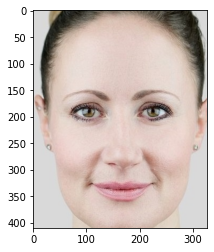

In [19]:
im = cv2.imread('test.jpg')
test_data = train.preprocess_image(im).to(device)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
gender, age = model(test_data)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = torch.argmax(age, dim=1).detach().numpy()
print('Predicted gender:', np.where(pred_gender[0][0] < 0.5, 'Male','Female'), pred_gender[0][0])
print('Predicted age:', train.get_age(pred_age)) 